In [49]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.advanced_activations import LeakyReLU

In [50]:
img_shape = (512, 512, 3)
z_dim = 100

In [51]:
def generator(img_shape, z_dim):
    
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(512*512*3, activation='tanh'))
    model.add(Reshape(img_shape))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

In [52]:
def discriminator(img_shape):
    
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    # Hidden layer
    model.add(Dense(128))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

In [53]:
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

In [54]:
def sample_images(iteration,image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1,(image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise 
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns,figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [55]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    
    # Load the dataset
    path = "images/train/pd"
    image_data= []    
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size=((512,512)))
        img_array = image.img_to_array(img)
        image_data.append(img_array)

        
    x_train = np.array(image_data)    
    print("x_train shape = " , x_train.shape)

    # Rescale -1 to 1
    X_train = x_train / 127.5 - 1.

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            sample_images(iteration)

x_train shape =  (12, 512, 512, 3)
0 [D loss: 0.556140, acc.: 50.00%] [G loss: 2.393034]
2 [D loss: 180.087479, acc.: 50.00%] [G loss: 0.000000]
4 [D loss: 342.418518, acc.: 50.00%] [G loss: 0.000000]
6 [D loss: 281.930237, acc.: 50.00%] [G loss: 0.000000]
8 [D loss: 24.134689, acc.: 50.00%] [G loss: 47.961136]
10 [D loss: 208.985642, acc.: 50.00%] [G loss: 5.739022]
12 [D loss: 3.040185, acc.: 50.00%] [G loss: 0.002693]
14 [D loss: 5.817582, acc.: 50.00%] [G loss: 0.000000]
16 [D loss: 6.297946, acc.: 50.00%] [G loss: 0.000139]
18 [D loss: 14.743954, acc.: 50.00%] [G loss: 0.000035]


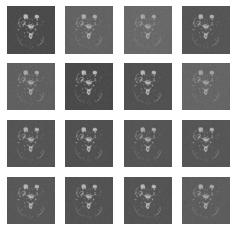

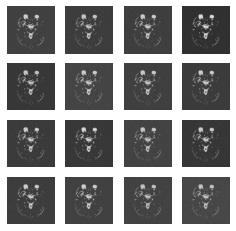

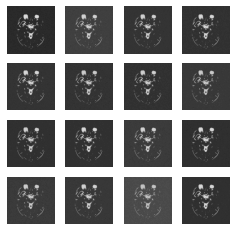

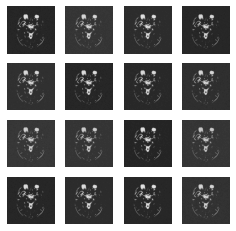

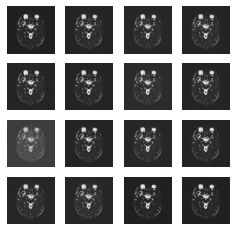

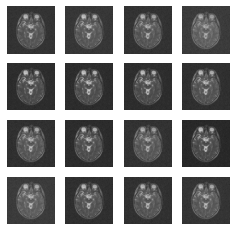

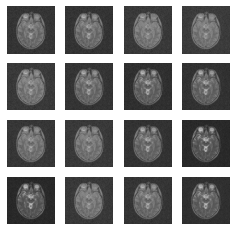

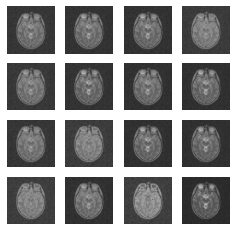

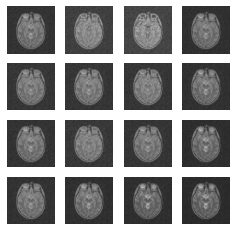

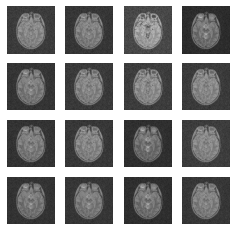

In [56]:
iterations = 20
batch_size = 2
sample_interval = 2

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)